## Stage 4
### Manish Shah
#### Utilize Linear and Non-Linear (polynomial) regression models to compare trends for a single state and its counties (top 5 with highest number of cases). Start your data from the first day of infections.
* X-Axis - number of days since the first case, Y - Axis number of new cases and deaths. Calcluate error using RMSE.
* Identify which counties are most at risk. Model for top 5 counties with cases within a state and describe their trends.
* Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.
* Perform hypothesis tests on questions identified in Stage II
* e.x. Does higher employment data (overall employment numbers) lead to higher covid case numbers or more rapid increase in covid cases.. Here you would compare the covid cases to the state or county level enrichment data to prove or disprove your null hypothesis. In this case there will be a two tail - two sample t-test to see if there is a difference and then one-tail - two sample t-test to show higher or lower.
* Depending on your type of data you can also perform Chi-square test for categorical hypothesis testing.

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
from IPython.display import Image
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import PolynomialFeatures
from IPython.display import Image
from sklearn.metrics import mean_squared_error

#import exception handling
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

### Reading the superdataset CSV file

In [2]:
data1 = pd.read_csv('../../../../data/stage_1/superdataset.csv')
#data1 = pd.read_csv('superdataset.csv')

In [3]:
data1

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population
0,0,statewide unallocated,AL,2020-01-22,0,0,0
1,0,statewide unallocated,AL,2020-01-23,0,0,0
2,0,statewide unallocated,AL,2020-01-24,0,0,0
3,0,statewide unallocated,AL,2020-01-25,0,0,0
4,0,statewide unallocated,AL,2020-01-26,0,0,0
...,...,...,...,...,...,...,...
2346471,56045,weston county,WY,2022-02-03,1491,17,6927
2346472,56045,weston county,WY,2022-02-04,1496,17,6927
2346473,56045,weston county,WY,2022-02-05,1496,17,6927
2346474,56045,weston county,WY,2022-02-06,1496,17,6927


#### copying the dataset to a new variable to original data remains intact

In [4]:
data = data1

#### Converting date column to datetime from string and removing "State Unallocated" 

In [5]:
data['Date'] = data.Date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))
#remove all empty rows, removing state unallocated.
data = data[data.countyFIPS != 0]

In [6]:
data

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population
748,1001,autauga county,AL,2020-01-22,0,0,55869
749,1001,autauga county,AL,2020-01-23,0,0,55869
750,1001,autauga county,AL,2020-01-24,0,0,55869
751,1001,autauga county,AL,2020-01-25,0,0,55869
752,1001,autauga county,AL,2020-01-26,0,0,55869
...,...,...,...,...,...,...,...
2346471,56045,weston county,WY,2022-02-03,1491,17,6927
2346472,56045,weston county,WY,2022-02-04,1496,17,6927
2346473,56045,weston county,WY,2022-02-05,1496,17,6927
2346474,56045,weston county,WY,2022-02-06,1496,17,6927


#### Adding columns of confirmed_daily and deaths_daily to data using diff() to take difference of consecutive element difference 

In [7]:
data['confirmed_daily'] = data['Confirmed'].diff()

In [8]:
data['deaths_daily'] = data['Deaths'].diff()
data = data.iloc[1: , :]
data

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,confirmed_daily,deaths_daily
749,1001,autauga county,AL,2020-01-23,0,0,55869,0.0,0.0
750,1001,autauga county,AL,2020-01-24,0,0,55869,0.0,0.0
751,1001,autauga county,AL,2020-01-25,0,0,55869,0.0,0.0
752,1001,autauga county,AL,2020-01-26,0,0,55869,0.0,0.0
753,1001,autauga county,AL,2020-01-27,0,0,55869,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2346471,56045,weston county,WY,2022-02-03,1491,17,6927,6.0,0.0
2346472,56045,weston county,WY,2022-02-04,1496,17,6927,5.0,0.0
2346473,56045,weston county,WY,2022-02-05,1496,17,6927,0.0,0.0
2346474,56045,weston county,WY,2022-02-06,1496,17,6927,0.0,0.0


### Selecting NC as my state for evaluation
#### Select NC data from the dataframe

In [55]:
nc = data[data.State == 'NC']

In [56]:
nc

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,confirmed_daily,deaths_daily
1426436,37001,alamance county,NC,2020-01-22,0,0,169509,-3193.0,-37.0
1426437,37001,alamance county,NC,2020-01-23,0,0,169509,0.0,0.0
1426438,37001,alamance county,NC,2020-01-24,0,0,169509,0.0,0.0
1426439,37001,alamance county,NC,2020-01-25,0,0,169509,0.0,0.0
1426440,37001,alamance county,NC,2020-01-26,0,0,169509,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1501231,37199,yancey county,NC,2022-02-03,4425,46,18069,18.0,1.0
1501232,37199,yancey county,NC,2022-02-04,4439,48,18069,14.0,2.0
1501233,37199,yancey county,NC,2022-02-05,4439,48,18069,0.0,0.0
1501234,37199,yancey county,NC,2022-02-06,4439,48,18069,0.0,0.0


#### Perform groupby Date and doing sum of all columns

In [57]:
nc = nc.groupby(["Date"]).sum().reset_index()
nc

,Date,countyFIPS,Confirmed,Deaths,population,confirmed_daily,deaths_daily
0,2020-01-22,3710000,0,0,10488084,-2491705.0,-21237.0
1,2020-01-23,3710000,0,0,10488084,0.0,0.0
2,2020-01-24,3710000,0,0,10488084,0.0,0.0
3,2020-01-25,3710000,0,0,10488084,0.0,0.0
4,2020-01-26,3710000,0,0,10488084,0.0,0.0
...,...,...,...,...,...,...,...
743,2022-02-03,3710000,2456386,21027,10488084,14980.0,123.0
744,2022-02-04,3710000,2468806,21097,10488084,12420.0,70.0
745,2022-02-05,3710000,2468806,21097,10488084,0.0,0.0
746,2022-02-06,3710000,2468806,21097,10488084,0.0,0.0


#### Removing the first row of data with garbage values

In [58]:
nc = nc.iloc[1: , :]
nc

,Date,countyFIPS,Confirmed,Deaths,population,confirmed_daily,deaths_daily
1,2020-01-23,3710000,0,0,10488084,0.0,0.0
2,2020-01-24,3710000,0,0,10488084,0.0,0.0
3,2020-01-25,3710000,0,0,10488084,0.0,0.0
4,2020-01-26,3710000,0,0,10488084,0.0,0.0
5,2020-01-27,3710000,0,0,10488084,0.0,0.0
...,...,...,...,...,...,...,...
743,2022-02-03,3710000,2456386,21027,10488084,14980.0,123.0
744,2022-02-04,3710000,2468806,21097,10488084,12420.0,70.0
745,2022-02-05,3710000,2468806,21097,10488084,0.0,0.0
746,2022-02-06,3710000,2468806,21097,10488084,0.0,0.0


#### Find the first occurence of cases and deaths

I have referred to the below link to check for first occurence of cases.
* https://stackoverflow.com/questions/52226718/how-to-get-max-column-with-non-zero-value-in-a-pandas-dataframe
* https://stackoverflow.com/questions/41255215/pandas-find-first-occurrence

In [59]:
confirmed_day1 = nc.confirmed_daily.ne(0).idxmax()
deaths_day1 = nc.deaths_daily.ne(0).idxmax()

In [60]:
confirmed_day1

41

#### To start the data from that index, reseting the index  

In [61]:
nc1 = nc.iloc[43: , :]
nc1.reset_index(inplace = True)
nc1

,index,Date,countyFIPS,Confirmed,Deaths,population,confirmed_daily,deaths_daily
0,44,2020-03-06,3710000,2,0,10488084,1.0,0.0
1,45,2020-03-07,3710000,2,0,10488084,0.0,0.0
2,46,2020-03-08,3710000,2,0,10488084,0.0,0.0
3,47,2020-03-09,3710000,7,0,10488084,5.0,0.0
4,48,2020-03-10,3710000,8,0,10488084,1.0,0.0
...,...,...,...,...,...,...,...,...
699,743,2022-02-03,3710000,2456386,21027,10488084,14980.0,123.0
700,744,2022-02-04,3710000,2468806,21097,10488084,12420.0,70.0
701,745,2022-02-05,3710000,2468806,21097,10488084,0.0,0.0
702,746,2022-02-06,3710000,2468806,21097,10488084,0.0,0.0


#### Adding a column of first_occurence of cases in the dataframe

I have referred to the below link to set first_occurence column
* https://dev.to/nilotpalc/answer-how-to-add-incremental-numbers-to-a-new-column-using-pandas-4bc5

In [62]:
nc1.insert(0, 'first_occurence', 1+nc1.index)
nc1

,first_occurence,index,Date,countyFIPS,Confirmed,Deaths,population,confirmed_daily,deaths_daily
0,1,44,2020-03-06,3710000,2,0,10488084,1.0,0.0
1,2,45,2020-03-07,3710000,2,0,10488084,0.0,0.0
2,3,46,2020-03-08,3710000,2,0,10488084,0.0,0.0
3,4,47,2020-03-09,3710000,7,0,10488084,5.0,0.0
4,5,48,2020-03-10,3710000,8,0,10488084,1.0,0.0
...,...,...,...,...,...,...,...,...,...
699,700,743,2022-02-03,3710000,2456386,21027,10488084,14980.0,123.0
700,701,744,2022-02-04,3710000,2468806,21097,10488084,12420.0,70.0
701,702,745,2022-02-05,3710000,2468806,21097,10488084,0.0,0.0
702,703,746,2022-02-06,3710000,2468806,21097,10488084,0.0,0.0


#### Dropping the index column from the above dataframe

In [63]:
nc1.drop('index',axis=1, inplace = True)

In [64]:
nc1

,first_occurence,Date,countyFIPS,Confirmed,Deaths,population,confirmed_daily,deaths_daily
0,1,2020-03-06,3710000,2,0,10488084,1.0,0.0
1,2,2020-03-07,3710000,2,0,10488084,0.0,0.0
2,3,2020-03-08,3710000,2,0,10488084,0.0,0.0
3,4,2020-03-09,3710000,7,0,10488084,5.0,0.0
4,5,2020-03-10,3710000,8,0,10488084,1.0,0.0
...,...,...,...,...,...,...,...,...
699,700,2022-02-03,3710000,2456386,21027,10488084,14980.0,123.0
700,701,2022-02-04,3710000,2468806,21097,10488084,12420.0,70.0
701,702,2022-02-05,3710000,2468806,21097,10488084,0.0,0.0
702,703,2022-02-06,3710000,2468806,21097,10488084,0.0,0.0


## Linear Regression for cases

I have used the below reference to print linear regression
* https://www.youtube.com/watch?v=XynxBvUGgFk

In [139]:
model1 = smf.ols('confirmed_daily~first_occurence',nc1).fit()

In [140]:
model1.predict(nc1)

0      -644.776125
1      -632.808082
2      -620.840039
3      -608.871996
4      -596.903953
          ...     
699    7720.885977
700    7732.854020
701    7744.822063
702    7756.790106
703    7768.758149
Length: 700, dtype: float64

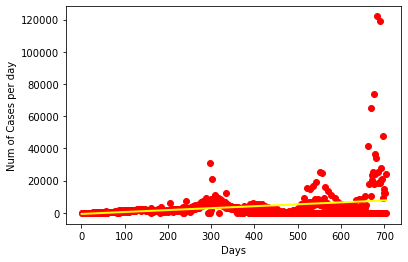

In [142]:
plt.scatter(nc1['first_occurence'],nc1['confirmed_daily'],color = 'red')
plt.plot(nc1['first_occurence'],model1.predict(nc1),color='yellow',linewidth = 2)
plt.xlabel('Days')
plt.ylabel('Num of Cases per day')
plt.show()

### Trendline for cases and deaths in NC

I have referred to this link to generate the trendline.
* https://plotly.com/python/ml-regression/

### I am making use of the team task to build prediction path and trendline

### Cases

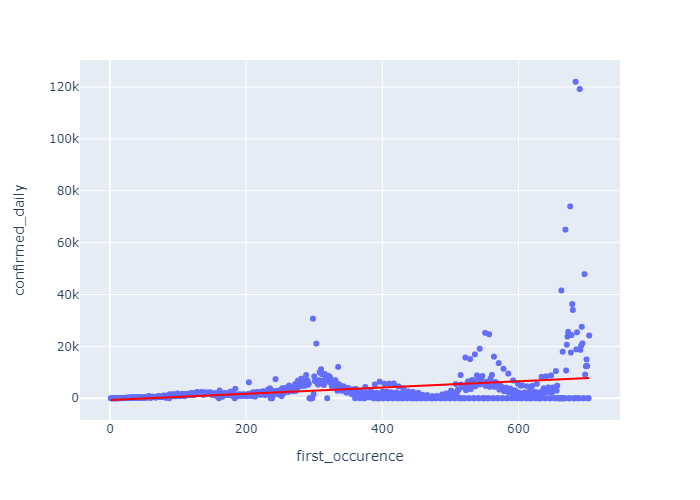

In [613]:
fig = px.scatter(nc1, x="first_occurence", y="confirmed_daily", trendline="ols",trendline_color_override="red")
#fig.show()
fig.write_image("1.png")
Image(filename="1.png")

### Deaths

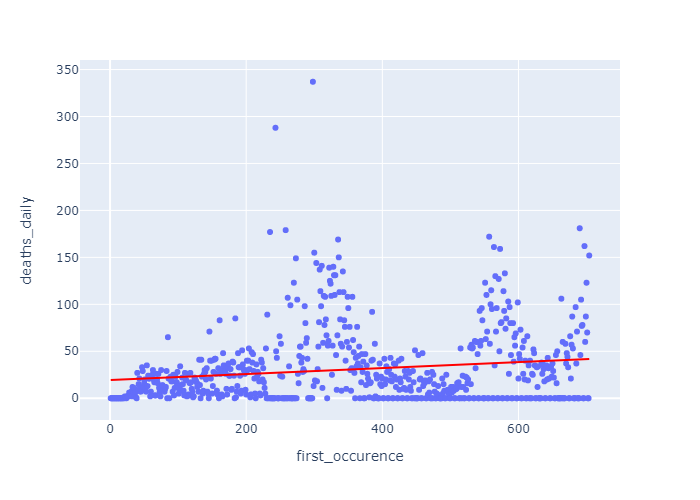

In [642]:
fig = px.scatter(nc1, x="first_occurence", y="deaths_daily", trendline="ols",trendline_color_override="red")
#fig.show()
fig.write_image("1.png")
Image(filename="1.png")

#### We already have 704 rows in the datasets
#### Let us add 7 other days to it and build the trendline to forecast cases.

In [627]:
#Add 7 days to the cases and deaths
additional_dates = range(704, 711, 1)
additional_dates = list(aaditional_dates)
additional_dates = np.arange(704,711).reshape(-1,1)

#Generate a model for cases and fit it
m1 = LinearRegression()
m1.fit(x_train,y1)

##Generate a model for deaths and fit it
m2 = LinearRegression()
m2.fit(x_train_t,y_train_t)


#new cases forecast for 7 days
additional_cases = m1.predict(additional_dates)
addtional_deaths = m2.predict(additional_dates)

In [637]:
# Add additional case and additional death to a new dataframe p and q.

In [628]:
p = pd.DataFrame(additional_cases)
r = pd.DataFrame(addtional_deaths)

#### concating new cases and deaths to the bottom of confirmed_daily and deaths_daily

In [640]:
nc_added=nc1
f1 = [nc_added['confirmed_daily'], p]
result = pd.concat(f1)
# deaths
f2 = [nc_added['deaths_daily'], r]
result2 = pd.concat(f2)

#### renaming the columns of the dataframe

In [630]:
result.rename(columns = {0: 'Num of Cases per day'}, inplace = True)
result2.rename(columns = {0: 'Num of Deaths per day'}, inplace = True)

#### Adding values to the bottom of first_occurences

In [631]:
q = pd.DataFrame(additional_dates)
frames1 = [nc_added['first_occurence'], q]
result1 = pd.concat(frames1)
result1.rename(columns = {0: 'first_occurence'}, inplace = True)

#### Concatenating the values of cases, deaths and dates to create a new dataframe

In [634]:
df1 = pd.concat([result, result1,result2], axis=1)
df1

,Num of Cases per day,first_occurence,Num of Deaths per day
0,1.000000,1,0.000000
1,0.000000,2,0.000000
2,0.000000,3,0.000000
3,5.000000,4,0.000000
4,1.000000,5,0.000000
...,...,...,...
2,2848.293028,706,8.552066
3,2852.905703,707,8.557123
4,2857.518378,708,8.562181
5,2862.131053,709,8.567239


### Trendline for cases with forecast of 1 week ahead (Future prediction for cases)

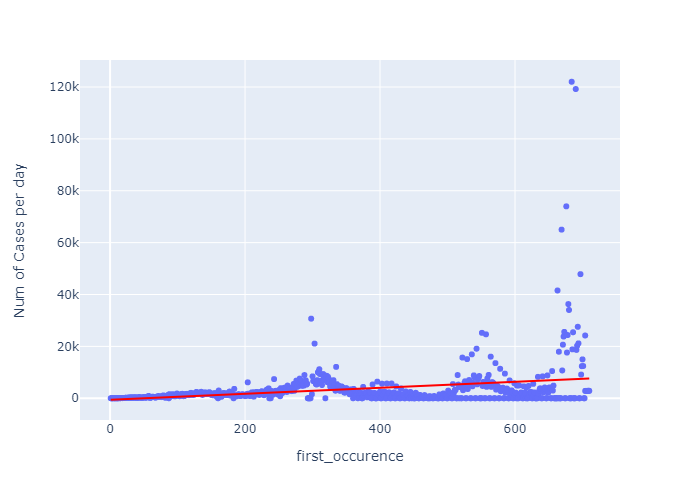

In [636]:
#Updated forecast for 7 days
fig = px.scatter(df1, x="first_occurence", y="Num of Cases per day", trendline="ols",trendline_color_override="red")
#fig.show()
fig.write_image("2.png")
Image(filename="2.png")

### Trendline for deaths with forecast of 1 week ahead (future predictions for deaths)

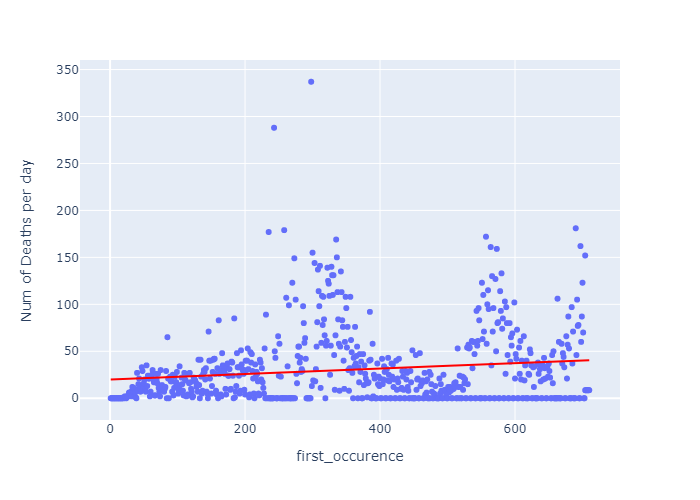

In [643]:
#Updated forecast for 7 days
fig = px.scatter(df1, x="first_occurence", y="Num of Deaths per day", trendline="ols",trendline_color_override="red")
#fig.show()
fig.write_image("2.png")
Image(filename="2.png")

In [68]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        first_occurence   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     57.86
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           9.08e-14
Time:                        08:58:41   Log-Likelihood:                -4712.3
No. Observations:                 704   AIC:                             9429.
Df Residuals:                     702   BIC:                             9438.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         329.9126      7.948     41.508      0.000     314.308     345.517
confirmed_daily     0.0064      0.001      7.606      0.000       0.005       0.008
==============================================================================
Omnibus:                      488.163   Durbin-Watson:                   0.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.413
Skew:                           0.028   Prob(JB):                     6.17e-10
Kurtosis:                       1.799   Cond. No.                     1.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Linear Regression for Deaths

In [81]:
nc1[nc1['deaths_daily']<0]
nc1 = nc1.drop([232])
nc1 = nc1.drop([301])
nc1 = nc1.drop([482])
nc1 = nc1.drop([494])
nc1

,first_occurence,Date,countyFIPS,Confirmed,Deaths,population,confirmed_daily,deaths_daily
0,1,2020-03-06,3710000,2,0,10488084,1.0,0.0
1,2,2020-03-07,3710000,2,0,10488084,0.0,0.0
2,3,2020-03-08,3710000,2,0,10488084,0.0,0.0
3,4,2020-03-09,3710000,7,0,10488084,5.0,0.0
4,5,2020-03-10,3710000,8,0,10488084,1.0,0.0
...,...,...,...,...,...,...,...,...
699,700,2022-02-03,3710000,2456386,21027,10488084,14980.0,123.0
700,701,2022-02-04,3710000,2468806,21097,10488084,12420.0,70.0
701,702,2022-02-05,3710000,2468806,21097,10488084,0.0,0.0
702,703,2022-02-06,3710000,2468806,21097,10488084,0.0,0.0


In [136]:
model2 = smf.ols('deaths_daily~first_occurence',nc1).fit()

In [135]:
nc1['deaths_daily'].max()

337.0

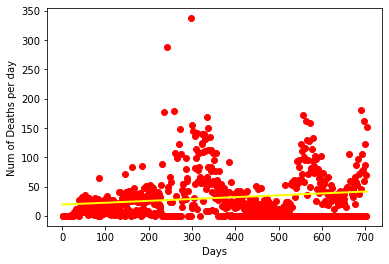

In [138]:
plt.scatter(nc1['first_occurence'],nc1['deaths_daily'],color = 'red')
plt.plot(nc1['first_occurence'],model2.predict(nc1),color='yellow',linewidth = 2)
plt.xlabel('Days')
plt.ylabel('Num of Deaths per day')
plt.show()

In [143]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           deaths_daily   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     19.48
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           1.18e-05
Time:                        09:17:53   Log-Likelihood:                -3552.3
No. Observations:                 700   AIC:                             7109.
Df Residuals:                     698   BIC:                             7118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          19.3072      2.928      6.595      0.000      13.559      25.055
first_occurence     0.0318      0.007      4.414      0.000       0.018       0.046
==============================================================================
Omnibus:                      393.895   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3505.759
Skew:                           2.398   Prob(JB):                         0.00
Kurtosis:                      12.858   Cond. No.                         813.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Non-Linear (polynomial) regression for cases

#### I am using the same code for non linear regression as it was used in Team Task. The code was referred from the below link:
* https://www.youtube.com/watch?v=SSmpyoIdJTc&feature=youtu.be

In [656]:
X1 = nc1[['first_occurence']]
y1 = nc1['confirmed_daily']

In [657]:
x_train, x_test, y_train, y_test = train_test_split(X1,y1)

In [658]:
poly2 = PolynomialFeatures(degree = 2)
poly3 = PolynomialFeatures(degree = 3)
poly4 = PolynomialFeatures(degree = 4)

In [659]:
x_train = x_train.to_numpy()

In [660]:
X_train_poly2 = poly2.fit_transform(x_train)

X_train_poly3 = poly3.fit_transform(x_train)

X_train_poly4 = poly4.fit_transform(x_train)

In [661]:
y1 = pd.DataFrame(y_train)

In [662]:
X_test_poly = poly2.fit_transform(x_test)

In [663]:
from sklearn import linear_model
model2 = linear_model.LinearRegression()
model3 = linear_model.LinearRegression()
model4 = linear_model.LinearRegression()
#model = linear_model.LinearRegression()

#degree 2
model2 = model2.fit(X_train_poly2,y1)

#degree 3
model3 = model3.fit(X_train_poly3,y1)

#degree 4
model4 = model4.fit(X_train_poly4,y1)

In [664]:
coefficient2 = model2.coef_
coefficient3 = model3.coef_
coefficient4 = model4.coef_
intercept2 = model2.intercept_
intercept3 = model3.intercept_
intercept4 = model4.intercept_

In [167]:
#Flattening to one dimenstional

In [665]:
coefficient2 = coefficient2.flatten()
coefficient3 = coefficient3.flatten()
coefficient4 = coefficient4.flatten()

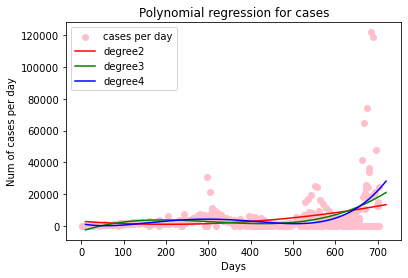

In [666]:
x_axis = np.arange(10,720,0.1)

response2  = intercept2 + coefficient2[1]*x_axis + coefficient2[2]*x_axis**2 
response3  = intercept3 + coefficient3[1]*x_axis + coefficient3[2]*x_axis**2 + coefficient3[3]*x_axis**3
response4  = intercept4 + coefficient4[1]*x_axis + coefficient4[2]*x_axis**2 + coefficient4[3]*x_axis**3 + coefficient4[4]*x_axis**4


plt.scatter(x_train,y1,color = 'pink')
plt.plot(x_axis,response2, color = 'r') 
plt.plot(x_axis,response3, color = 'g') 
plt.plot(x_axis,response4, color = 'b') 
plt.xlabel('Days')
plt.title("Polynomial regression for cases")
plt.legend(["cases per day", "degree2","degree3","degree4"], loc ="upper left")
plt.ticklabel_format(style='plain')
plt.ylabel('Num of cases per day')
plt.show()

## Confidence intervals for Cases:

I have referred the below code from the lecture notes of Dr. Mohanty
* https://github.com/UNCG-CSE/CSC-405-605_Spring_2022/blob/main/Class_Resources/Lecture_06/Statistics/05_Hypothesis.ipynb

In [720]:
sigma = y_train.std()/np.sqrt(50)  # Sample stdev/sample size

stats.t.interval(0.99,                        # Confidence level
                 df = 49,                     # Degrees of freedom
                 loc = x_train.mean(), # Sample mean
                 scale= sigma) 

(-3405.797434293013, 4108.707910483489)

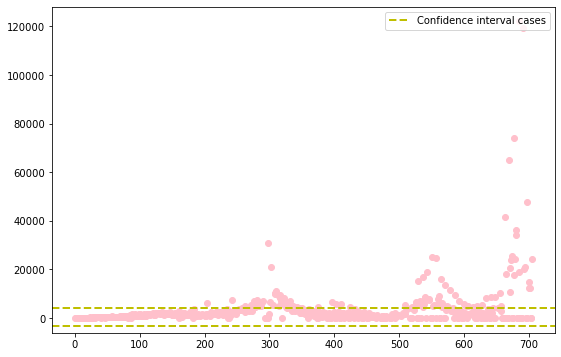

In [713]:
plt.figure(figsize=(9,6))
plt.scatter(x_train,y1,color = 'pink')
plt.axhline(-3405.797434293013, color='y', linestyle='dashed', linewidth=2, label='Confidence interval cases')
plt.axhline(4108.707910483489, color='y', linestyle='dashed', linewidth=2)
plt.legend(loc='upper right')
plt.show()

### Calculating RMSE

I have referred the below link to calculate RMSE
* https://www.geeksforgeeks.org/python-mean-squared-error/

In [191]:
modelPred_nlc = model.predict(x_test)

In [177]:
from sklearn.metrics import mean_squared_error
print('RMSE: ',np.sqrt(mean_squared_error(y_test,modelPred_nlc)))

RMSE:  6628.940455731941


## Non-Linear (polynomial) regression for deaths

#### I am using the same code for non linear regression as it was used in Team Task done my Manish & Priyanka. The code was referred from the below link:
* https://www.youtube.com/watch?v=SSmpyoIdJTc&feature=youtu.be

In [698]:
X2 = nc1[['first_occurence']]
y2 = nc1['deaths_daily']

In [699]:
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(X2, y2)

In [700]:
X_train_poly2_d = poly2.fit_transform(x_train_t)
X_train_poly3_d = poly3.fit_transform(x_train_t)
X_train_poly4_d = poly4.fit_transform(x_train_t)

In [702]:
x_train = x_train.to_numpy()

In [703]:
y2 = pd.DataFrame(y_train_t)

In [704]:
from sklearn import linear_model
model2_d = linear_model.LinearRegression()
model3_d = linear_model.LinearRegression()
model4_d = linear_model.LinearRegression()
#model = linear_model.LinearRegression()

#degree 2
model2_d = model2_d.fit(X_train_poly2_d,y2)

#degree 3
model3_d = model3_d.fit(X_train_poly3_d,y2)

#degree 4
model4_d = model4_d.fit(X_train_poly4_d,y2)

In [705]:
coefficient2_d = model2_d.coef_
coefficient3_d = model3_d.coef_
coefficient4_d = model4_d.coef_
intercept2_d = model2_d.intercept_
intercept3_d = model3_d.intercept_
intercept4_d = model4_d.intercept_

In [ ]:
#Flattening to one dimension

In [706]:
coefficient2_d = coefficient2_d.flatten()
coefficient3_d = coefficient3_d.flatten()
coefficient4_d = coefficient4_d.flatten()

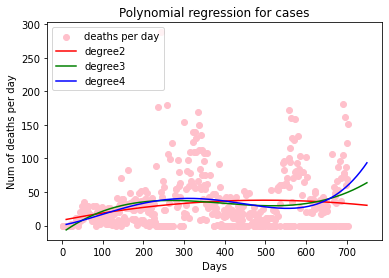

In [707]:
x_axis = np.arange(10,750,0.1)

response2_d  = intercept2_d + coefficient2_d[1]*x_axis + coefficient2_d[2]*x_axis**2 
response3_d  = intercept3_d + coefficient3_d[1]*x_axis + coefficient3_d[2]*x_axis**2 + coefficient3_d[3]*x_axis**3
response4_d  = intercept4_d + coefficient4_d[1]*x_axis + coefficient4_d[2]*x_axis**2 + coefficient4_d[3]*x_axis**3 + coefficient4_d[4]*x_axis**4

plt.scatter(x_train_t,y2,color = 'pink')
plt.plot(x_axis,response2_d, color = 'r') 
plt.plot(x_axis,response3_d, color = 'g') 
plt.plot(x_axis,response4_d, color = 'b') 
plt.xlabel('Days')
plt.title("Polynomial regression for cases")
plt.legend(["deaths per day", "degree2","degree3","degree4"], loc ="upper left")
plt.ticklabel_format(style='plain')
plt.ylabel('Num of deaths per day')
plt.show()

## Confidence intervals for deaths

I have referred the below code from the lecture notes of Dr. Mohanty
* https://github.com/UNCG-CSE/CSC-405-605_Spring_2022/blob/main/Class_Resources/Lecture_06/Statistics/05_Hypothesis.ipynb

In [717]:
sigma = x_train_t.std()/np.sqrt(50)  # Sample stdev/sample size

stats.t.interval(0.99,                        # Confidence level
                 df = 49,                     # Degrees of freedom
                 loc = y_train_t.mean(), # Sample mean
                 scale= sigma) 

(array([-46.35268299]), array([107.4422068]))

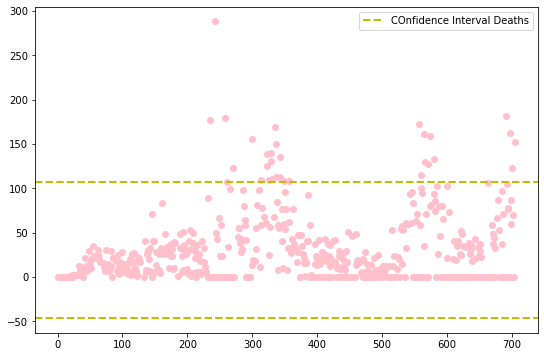

In [718]:
plt.figure(figsize=(9,6))
plt.scatter(x_train_t,y2,color = 'pink')
plt.axhline(-46.35268299, color='y', linestyle='dashed', linewidth=2, label='Confidence Interval Deaths')
plt.axhline(107.4422068, color='y', linestyle='dashed', linewidth=2)
plt.legend(loc='upper right')
plt.show()

### Calculating RMSE for deaths

In [192]:
modelPred_nld = model.predict(x_test_t)

In [193]:
from sklearn.metrics import mean_squared_error
print('RMSE: ',np.sqrt(mean_squared_error(y_test_t,modelPred_nld)))

RMSE:  4445.892972088971


# County Level implementation

### Selecting (state = NC) from main dataset

In [378]:
nc_county = data
nc_county = nc_county[nc_county['State'] =='NC']
nc_county

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,confirmed_daily,deaths_daily
1426436,37001,alamance county,NC,2020-01-22,0,0,169509,-3193.0,-37.0
1426437,37001,alamance county,NC,2020-01-23,0,0,169509,0.0,0.0
1426438,37001,alamance county,NC,2020-01-24,0,0,169509,0.0,0.0
1426439,37001,alamance county,NC,2020-01-25,0,0,169509,0.0,0.0
1426440,37001,alamance county,NC,2020-01-26,0,0,169509,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1501231,37199,yancey county,NC,2022-02-03,4425,46,18069,18.0,1.0
1501232,37199,yancey county,NC,2022-02-04,4439,48,18069,14.0,2.0
1501233,37199,yancey county,NC,2022-02-05,4439,48,18069,0.0,0.0
1501234,37199,yancey county,NC,2022-02-06,4439,48,18069,0.0,0.0


#### Grouping the data by county_name and sorting it by confirmed_daily

In [349]:
nc_county_grp = nc_county.groupby(["County_Name"]).sum().reset_index()
nc_county_grp
nc_county_grp.sort_values(by = 'confirmed_daily',ascending=False)

,County_Name,countyFIPS,Confirmed,Deaths,population,confirmed_daily,deaths_daily
91,wake county,27812884,47919339,341878,831597228,263507.0,859.0
59,mecklenburg county,27765012,59613482,489387,830546288,261121.0,1392.0
40,guilford county,27736588,24543860,334642,401806152,104962.0,957.0
33,forsyth county,27726116,19114236,201742,285956660,75484.0,572.0
89,union county,27809892,12917651,117194,179414532,58169.0,421.0
...,...,...,...,...,...,...,...
34,franklin county,27727612,3565786,28586,52124380,-69353.0,-643.0
26,currituck county,27715644,876505,8399,20766724,-73862.0,-487.0
41,halifax county,27738084,2902452,51366,37407480,-97032.0,-846.0
60,mitchell county,27766508,730488,7757,11193072,-263926.0,-1440.0


So from the above data, it can be seen top 5 counties with most confirmed_cases_daily are:
1. wake county	
2. mecklenburg county
3. guilford county
4. forsyth county
5. union county

### Taking out these counties data from the NC data

In [379]:
county_list = ['wake county','mecklenburg county','guilford county','forsyth county','union county']
nc_county = nc_county[nc_county.County_Name.isin(county_list)]
nc_county = nc_county.iloc[1: , :]
nc_county.reset_index(inplace=True)

In [380]:
nc_county = nc_county.groupby(["Date"]).sum().reset_index()
nc_county

,Date,index,countyFIPS,Confirmed,Deaths,population,confirmed_daily,deaths_daily
0,2020-01-22,5914436,148562,0,0,2999150,-23811.0,-254.0
1,2020-01-23,7365561,185629,0,0,3381445,0.0,0.0
2,2020-01-24,7365566,185629,0,0,3381445,0.0,0.0
3,2020-01-25,7365571,185629,0,0,3381445,0.0,0.0
4,2020-01-26,7365576,185629,0,0,3381445,0.0,0.0
...,...,...,...,...,...,...,...,...
743,2022-02-03,7369271,185629,789120,4560,3381445,3737.0,30.0
744,2022-02-04,7369276,185629,792764,4579,3381445,3644.0,19.0
745,2022-02-05,7369281,185629,792764,4579,3381445,0.0,0.0
746,2022-02-06,7369286,185629,792764,4579,3381445,0.0,0.0


In [381]:
nc_county

,Date,index,countyFIPS,Confirmed,Deaths,population,confirmed_daily,deaths_daily
0,2020-01-22,5914436,148562,0,0,2999150,-23811.0,-254.0
1,2020-01-23,7365561,185629,0,0,3381445,0.0,0.0
2,2020-01-24,7365566,185629,0,0,3381445,0.0,0.0
3,2020-01-25,7365571,185629,0,0,3381445,0.0,0.0
4,2020-01-26,7365576,185629,0,0,3381445,0.0,0.0
...,...,...,...,...,...,...,...,...
743,2022-02-03,7369271,185629,789120,4560,3381445,3737.0,30.0
744,2022-02-04,7369276,185629,792764,4579,3381445,3644.0,19.0
745,2022-02-05,7369281,185629,792764,4579,3381445,0.0,0.0
746,2022-02-06,7369286,185629,792764,4579,3381445,0.0,0.0


In [382]:
nc_county.drop('index',axis=1, inplace = True)
#nc_county.drop('level_0',axis=1, inplace = True)
#nc_county.reset_index(inplace = True)
nc_county = nc_county.iloc[1: , :]
nc_county

,Date,countyFIPS,Confirmed,Deaths,population,confirmed_daily,deaths_daily
1,2020-01-23,185629,0,0,3381445,0.0,0.0
2,2020-01-24,185629,0,0,3381445,0.0,0.0
3,2020-01-25,185629,0,0,3381445,0.0,0.0
4,2020-01-26,185629,0,0,3381445,0.0,0.0
5,2020-01-27,185629,0,0,3381445,0.0,0.0
...,...,...,...,...,...,...,...
743,2022-02-03,185629,789120,4560,3381445,3737.0,30.0
744,2022-02-04,185629,792764,4579,3381445,3644.0,19.0
745,2022-02-05,185629,792764,4579,3381445,0.0,0.0
746,2022-02-06,185629,792764,4579,3381445,0.0,0.0


### Find first occurence of cases and deaths

In [388]:
confirmed_day_county = nc_county.confirmed_daily.ne(0).idxmax()
deaths_day_county = nc_county.deaths_daily.ne(0).idxmax()
confirmed_day_county

41

In [387]:
nc_county = nc_county.iloc[40: , :]
nc_county

,Date,countyFIPS,Confirmed,Deaths,population,confirmed_daily,deaths_daily
41,2020-03-03,185629,1,0,3381445,1.0,0.0
42,2020-03-04,185629,1,0,3381445,0.0,0.0
43,2020-03-05,185629,1,0,3381445,0.0,0.0
44,2020-03-06,185629,1,0,3381445,0.0,0.0
45,2020-03-07,185629,1,0,3381445,0.0,0.0
...,...,...,...,...,...,...,...
743,2022-02-03,185629,789120,4560,3381445,3737.0,30.0
744,2022-02-04,185629,792764,4579,3381445,3644.0,19.0
745,2022-02-05,185629,792764,4579,3381445,0.0,0.0
746,2022-02-06,185629,792764,4579,3381445,0.0,0.0


#### changing all negative values of cases_daily to zero

In [390]:
nc_county[nc_county['confirmed_daily']<0] = 0
nc_county[nc_county['deaths_daily']<0] = 0
nc_county.reset_index(inplace = True)
nc_county.drop('index',axis=1, inplace = True)
#nc_county.drop('level_0',axis=1, inplace = True)
nc_county

,Date,countyFIPS,Confirmed,Deaths,population,confirmed_daily,deaths_daily
0,2020-03-03 00:00:00,185629,1,0,3381445,1.0,0.0
1,2020-03-04 00:00:00,185629,1,0,3381445,0.0,0.0
2,2020-03-05 00:00:00,185629,1,0,3381445,0.0,0.0
3,2020-03-06 00:00:00,185629,1,0,3381445,0.0,0.0
4,2020-03-07 00:00:00,185629,1,0,3381445,0.0,0.0
...,...,...,...,...,...,...,...
702,2022-02-03 00:00:00,185629,789120,4560,3381445,3737.0,30.0
703,2022-02-04 00:00:00,185629,792764,4579,3381445,3644.0,19.0
704,2022-02-05 00:00:00,185629,792764,4579,3381445,0.0,0.0
705,2022-02-06 00:00:00,185629,792764,4579,3381445,0.0,0.0


In [392]:
# Removing all the dates with value not in the correct format
nc_county = nc_county[nc_county.Date != 0]

In [393]:
nc_county

,Date,countyFIPS,Confirmed,Deaths,population,confirmed_daily,deaths_daily
0,2020-03-03 00:00:00,185629,1,0,3381445,1.0,0.0
1,2020-03-04 00:00:00,185629,1,0,3381445,0.0,0.0
2,2020-03-05 00:00:00,185629,1,0,3381445,0.0,0.0
3,2020-03-06 00:00:00,185629,1,0,3381445,0.0,0.0
4,2020-03-07 00:00:00,185629,1,0,3381445,0.0,0.0
...,...,...,...,...,...,...,...
702,2022-02-03 00:00:00,185629,789120,4560,3381445,3737.0,30.0
703,2022-02-04 00:00:00,185629,792764,4579,3381445,3644.0,19.0
704,2022-02-05 00:00:00,185629,792764,4579,3381445,0.0,0.0
705,2022-02-06 00:00:00,185629,792764,4579,3381445,0.0,0.0


### Adding another column first_occurence for getting the first occurence of confirmed cases data

In [244]:
nc_county[nc_county['confirmed_daily']<0]
nc_county = nc_county.drop([745])
#nc_county = nc_county.drop([1258])
#nc_county = nc_county.drop([1279])
#nc_county = nc_county.drop([1493])
#nc_county = nc_county.drop([2241])
#nc_county = nc_county.drop([2989])
nc_county

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,confirmed_daily,deaths_daily
3,37067,forsyth county,NC,2020-01-28,0,0,382295,0.0,0.0
4,37067,forsyth county,NC,2020-01-29,0,0,382295,0.0,0.0
5,37067,forsyth county,NC,2020-01-30,0,0,382295,0.0,0.0
6,37067,forsyth county,NC,2020-01-31,0,0,382295,0.0,0.0
7,37067,forsyth county,NC,2020-02-01,0,0,382295,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3732,37183,wake county,NC,2022-02-03,270169,967,1111761,1429.0,0.0
3733,37183,wake county,NC,2022-02-04,271715,969,1111761,1546.0,2.0
3734,37183,wake county,NC,2022-02-05,271715,969,1111761,0.0,0.0
3735,37183,wake county,NC,2022-02-06,271715,969,1111761,0.0,0.0


#### Replacing all negative values with 0.
#### Removing dates in invalid formats

In [394]:
nc_county.insert(0, 'first_occurence', 1+nc_county.index)
nc_county

,first_occurence,Date,countyFIPS,Confirmed,Deaths,population,confirmed_daily,deaths_daily
0,1,2020-03-03 00:00:00,185629,1,0,3381445,1.0,0.0
1,2,2020-03-04 00:00:00,185629,1,0,3381445,0.0,0.0
2,3,2020-03-05 00:00:00,185629,1,0,3381445,0.0,0.0
3,4,2020-03-06 00:00:00,185629,1,0,3381445,0.0,0.0
4,5,2020-03-07 00:00:00,185629,1,0,3381445,0.0,0.0
...,...,...,...,...,...,...,...,...
702,703,2022-02-03 00:00:00,185629,789120,4560,3381445,3737.0,30.0
703,704,2022-02-04 00:00:00,185629,792764,4579,3381445,3644.0,19.0
704,705,2022-02-05 00:00:00,185629,792764,4579,3381445,0.0,0.0
705,706,2022-02-06 00:00:00,185629,792764,4579,3381445,0.0,0.0


## Linear Regression for county cases 

I have used the below reference to print linear regression
* https://www.youtube.com/watch?v=XynxBvUGgFk

In [398]:
model3c = smf.ols('confirmed_daily~first_occurence',nc_county).fit()

In [399]:
model3c.predict(nc_county)

0      -294.134316
1      -290.081504
2      -286.028692
3      -281.975880
4      -277.923067
          ...     
702    2550.939854
703    2554.992666
704    2559.045479
705    2563.098291
706    2567.151103
Length: 703, dtype: float64

## For Cases countywise:

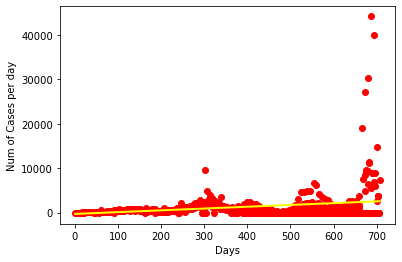

In [400]:
plt.scatter(nc_county['first_occurence'],nc_county['confirmed_daily'],color = 'red')
plt.plot(nc_county['first_occurence'],model3c.predict(nc_county),color='yellow',linewidth = 2)
plt.xlabel('Days')
plt.ylabel('Num of Cases per day')
plt.show()

## Linear Regression for Deaths

In [401]:
model3d = smf.ols('deaths_daily~first_occurence',nc_county).fit()

In [402]:
model3d.predict(nc_county)

0      4.867263
1      4.872043
2      4.876823
3      4.881603
4      4.886382
         ...   
702    8.222724
703    8.227504
704    8.232284
705    8.237063
706    8.241843
Length: 703, dtype: float64

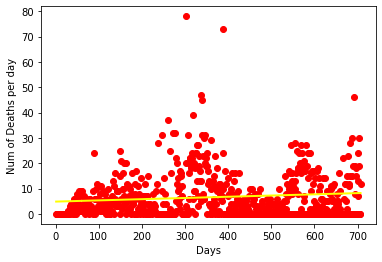

In [403]:
plt.scatter(nc_county['first_occurence'],nc_county['deaths_daily'],color = 'red')
plt.plot(nc_county['first_occurence'],model3d.predict(nc_county),color='yellow',linewidth = 2)
plt.xlabel('Days')
plt.ylabel('Num of Deaths per day')
plt.show()

## Non-Linear (polynomial) regression for cases

In [405]:
X1 = nc_county[['first_occurence']]
y1 = nc_county['confirmed_daily']
x_train, x_test, y_train, y_test = train_test_split(X1,y1)

In [406]:
poly2 = PolynomialFeatures(degree = 2)
poly3 = PolynomialFeatures(degree = 3)
poly4 = PolynomialFeatures(degree = 4)
x_train = x_train.to_numpy()

In [407]:
X_train_poly2 = poly2.fit_transform(x_train)

X_train_poly3 = poly3.fit_transform(x_train)

X_train_poly4 = poly4.fit_transform(x_train)

In [408]:
y1 = pd.DataFrame(y_train)

In [409]:
X_test_poly = poly2.fit_transform(x_test)

In [410]:
from sklearn import linear_model
model2 = linear_model.LinearRegression()
model3 = linear_model.LinearRegression()
model4 = linear_model.LinearRegression()
#model = linear_model.LinearRegression()

#degree 2
model2 = model2.fit(X_train_poly2,y1)

#degree 3
model3 = model3.fit(X_train_poly3,y1)

#degree 4
model4 = model4.fit(X_train_poly4,y1)

In [411]:
coefficient2 = model2.coef_
coefficient3 = model3.coef_
coefficient4 = model4.coef_
intercept2 = model2.intercept_
intercept3 = model3.intercept_
intercept4 = model4.intercept_

In [412]:
#Flattening the model

In [413]:
coefficient2 = coefficient2.flatten()
coefficient3 = coefficient3.flatten()
coefficient4 = coefficient4.flatten()

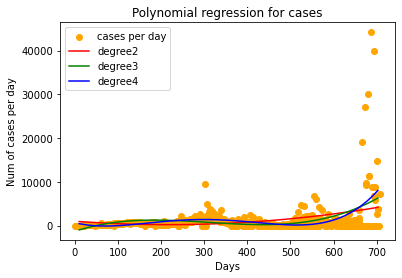

In [416]:
x_axis = np.arange(10,703,0.1)

response2  = intercept2 + coefficient2[1]*x_axis + coefficient2[2]*x_axis**2 
response3  = intercept3 + coefficient3[1]*x_axis + coefficient3[2]*x_axis**2 + coefficient3[3]*x_axis**3
response4  = intercept4 + coefficient4[1]*x_axis + coefficient4[2]*x_axis**2 + coefficient4[3]*x_axis**3 + coefficient4[4]*x_axis**4


plt.scatter(x_train,y1,color = 'orange')
plt.plot(x_axis,response2, color = 'r') 
plt.plot(x_axis,response3, color = 'g') 
plt.plot(x_axis,response4, color = 'b') 
plt.xlabel('Days')
plt.title("Polynomial regression for cases")
plt.legend(["cases per day", "degree2","degree3","degree4"], loc ="upper left")
plt.ticklabel_format(style='plain')
plt.ylabel('Num of cases per day')
plt.show()

### Calculating RMSE for county cases

In [417]:
modelPred_nlc = model.predict(x_test)
from sklearn.metrics import mean_squared_error
print('RMSE: ',np.sqrt(mean_squared_error(y_test,modelPred_nlc)))

RMSE:  3658.491945869049


## Non-Linear (polynomial) regression for county deaths

#### I am using the same code for non linear regression as it was used in Team Task done my Manish & Priyanka. The code was referred from the below link:
* https://www.youtube.com/watch?v=SSmpyoIdJTc&feature=youtu.be

In [419]:
X2 = nc_county[['first_occurence']]
y2 = nc_county['deaths_daily']
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(X2, y2)

In [420]:
X_train_poly2_d = poly2.fit_transform(x_train_t)
X_train_poly3_d = poly3.fit_transform(x_train_t)
X_train_poly4_d = poly4.fit_transform(x_train_t)

In [427]:
#x_train = x_train.to_numpy()

In [422]:
y2 = pd.DataFrame(y_train_t)

In [423]:
from sklearn import linear_model
model2_d = linear_model.LinearRegression()
model3_d = linear_model.LinearRegression()
model4_d = linear_model.LinearRegression()
#model = linear_model.LinearRegression()

#degree 2
model2_d = model2_d.fit(X_train_poly2_d,y2)

#degree 3
model3_d = model3_d.fit(X_train_poly3_d,y2)

#degree 4
model4_d = model4_d.fit(X_train_poly4_d,y2)

In [424]:
coefficient2_d = model2_d.coef_
coefficient3_d = model3_d.coef_
coefficient4_d = model4_d.coef_
intercept2_d = model2_d.intercept_
intercept3_d = model3_d.intercept_
intercept4_d = model4_d.intercept_

In [425]:
coefficient2_d = coefficient2_d.flatten()
coefficient3_d = coefficient3_d.flatten()
coefficient4_d = coefficient4_d.flatten()

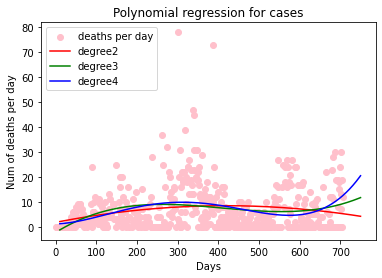

In [426]:
x_axis = np.arange(10,750,0.1)

response2_d  = intercept2_d + coefficient2_d[1]*x_axis + coefficient2_d[2]*x_axis**2 
response3_d  = intercept3_d + coefficient3_d[1]*x_axis + coefficient3_d[2]*x_axis**2 + coefficient3_d[3]*x_axis**3
response4_d  = intercept4_d + coefficient4_d[1]*x_axis + coefficient4_d[2]*x_axis**2 + coefficient4_d[3]*x_axis**3 + coefficient4_d[4]*x_axis**4

plt.scatter(x_train_t,y2,color = 'pink')
plt.plot(x_axis,response2_d, color = 'r') 
plt.plot(x_axis,response3_d, color = 'g') 
plt.plot(x_axis,response4_d, color = 'b') 
plt.xlabel('Days')
plt.title("Polynomial regression for cases")
plt.legend(["deaths per day", "degree2","degree3","degree4"], loc ="upper left")
plt.ticklabel_format(style='plain')
plt.ylabel('Num of deaths per day')
plt.show()

In [429]:
## RMSE for county deaths

In [430]:
modelPred_nld = model.predict(x_test_t)
from sklearn.metrics import mean_squared_error
print('RMSE: ',np.sqrt(mean_squared_error(y_test_t,modelPred_nld)))

RMSE:  4455.077538713576


### County wise data splitting

In [432]:
nc_county_wise = data
nc_county_wise = nc_county_wise[nc_county_wise['State'] =='NC']
nc_county_wise

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,confirmed_daily,deaths_daily
1426436,37001,alamance county,NC,2020-01-22,0,0,169509,-3193.0,-37.0
1426437,37001,alamance county,NC,2020-01-23,0,0,169509,0.0,0.0
1426438,37001,alamance county,NC,2020-01-24,0,0,169509,0.0,0.0
1426439,37001,alamance county,NC,2020-01-25,0,0,169509,0.0,0.0
1426440,37001,alamance county,NC,2020-01-26,0,0,169509,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1501231,37199,yancey county,NC,2022-02-03,4425,46,18069,18.0,1.0
1501232,37199,yancey county,NC,2022-02-04,4439,48,18069,14.0,2.0
1501233,37199,yancey county,NC,2022-02-05,4439,48,18069,0.0,0.0
1501234,37199,yancey county,NC,2022-02-06,4439,48,18069,0.0,0.0


In [433]:
county_list = ['wake county','mecklenburg county','guilford county','forsyth county','union county']
nc_county_wise = nc_county_wise[nc_county_wise.County_Name.isin(county_list)]
nc_county_wise = nc_county_wise.iloc[1: , :]
nc_county_wise.reset_index(inplace=True)
nc_county_wise

,index,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,confirmed_daily,deaths_daily
0,1451121,37067,forsyth county,NC,2020-01-23,0,0,382295,0.0,0.0
1,1451122,37067,forsyth county,NC,2020-01-24,0,0,382295,0.0,0.0
2,1451123,37067,forsyth county,NC,2020-01-25,0,0,382295,0.0,0.0
3,1451124,37067,forsyth county,NC,2020-01-26,0,0,382295,0.0,0.0
4,1451125,37067,forsyth county,NC,2020-01-27,0,0,382295,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3734,1495247,37183,wake county,NC,2022-02-03,270169,967,1111761,1429.0,0.0
3735,1495248,37183,wake county,NC,2022-02-04,271715,969,1111761,1546.0,2.0
3736,1495249,37183,wake county,NC,2022-02-05,271715,969,1111761,0.0,0.0
3737,1495250,37183,wake county,NC,2022-02-06,271715,969,1111761,0.0,0.0


In [439]:
#nc_county_wise.drop('index',axis=1, inplace = True)
#nc_county.drop('level_0',axis=1, inplace = True)
#nc_county.reset_index(inplace = True)
#nc_county_wise = nc_county_wise.iloc[1: , :]
nc_county_wise

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,confirmed_daily,deaths_daily
0,37067,forsyth county,NC,2020-01-23,0,0,382295,0.0,0.0
1,37067,forsyth county,NC,2020-01-24,0,0,382295,0.0,0.0
2,37067,forsyth county,NC,2020-01-25,0,0,382295,0.0,0.0
3,37067,forsyth county,NC,2020-01-26,0,0,382295,0.0,0.0
4,37067,forsyth county,NC,2020-01-27,0,0,382295,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3734,37183,wake county,NC,2022-02-03,270169,967,1111761,1429.0,0.0
3735,37183,wake county,NC,2022-02-04,271715,969,1111761,1546.0,2.0
3736,37183,wake county,NC,2022-02-05,271715,969,1111761,0.0,0.0
3737,37183,wake county,NC,2022-02-06,271715,969,1111761,0.0,0.0


In [554]:
#['wake county','mecklenburg county','guilford county','forsyth county','union county']

nc_county_w = nc_county_wise[nc_county_wise['County_Name'] == 'wake county']
nc_county_m = nc_county_wise[nc_county_wise['County_Name'] == 'mecklenburg county']
nc_county_g = nc_county_wise[nc_county_wise['County_Name'] == 'guilford county']
nc_county_f = nc_county_wise[nc_county_wise['County_Name'] == 'forsyth county']
nc_county_u = nc_county_wise[nc_county_wise['County_Name'] == 'union county']

In [473]:
# Reseting index for each dataframe

In [555]:
nc_county_w.reset_index(inplace = True)
nc_county_m.reset_index(inplace = True)
nc_county_g.reset_index(inplace = True)
nc_county_f.reset_index(inplace = True)
nc_county_u.reset_index(inplace = True)

In [556]:
nc_county_w = nc_county_w.iloc[1:,:]
nc_county_m = nc_county_m.iloc[1:,:]
nc_county_g = nc_county_g.iloc[1:,:]
nc_county_f = nc_county_f.iloc[1:,:]
nc_county_u = nc_county_u.iloc[1:,:]
nc_county_u

,index,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,confirmed_daily,deaths_daily
1,2244,37179,union county,NC,2020-01-23,0,0,239859,0.0,0.0
2,2245,37179,union county,NC,2020-01-24,0,0,239859,0.0,0.0
3,2246,37179,union county,NC,2020-01-25,0,0,239859,0.0,0.0
4,2247,37179,union county,NC,2020-01-26,0,0,239859,0.0,0.0
5,2248,37179,union county,NC,2020-01-27,0,0,239859,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
743,2986,37179,union county,NC,2022-02-03,58415,426,239859,274.0,1.0
744,2987,37179,union county,NC,2022-02-04,58635,426,239859,220.0,0.0
745,2988,37179,union county,NC,2022-02-05,58635,426,239859,0.0,0.0
746,2989,37179,union county,NC,2022-02-06,58635,426,239859,0.0,0.0


In [ ]:
#removing index, level_0 columns

In [557]:
nc_county_w.drop('index',axis=1, inplace = True)
#nc_county_w.drop('level_0',axis=1, inplace = True)

nc_county_m.drop('index',axis=1, inplace = True)
#nc_county_m.drop('level_0',axis=1, inplace = True)

nc_county_g.drop('index',axis=1, inplace = True)
#nc_county_g.drop('level_0',axis=1, inplace = True)

nc_county_f.drop('index',axis=1, inplace = True)
#nc_county_f.drop('level_0',axis=1, inplace = True)

nc_county_u.drop('index',axis=1, inplace = True)
#nc_county_u.drop('level_0',axis=1, inplace = True)


### Checking first occurences. For all county it is the same.

In [541]:
confirmed_day_county = nc_county_f.confirmed_daily.ne(0).idxmax()
confirmed_day_county

48

In [548]:
# starting from first occurence for each county

In [558]:
nc_county_w = nc_county_w.iloc[40: , :]
nc_county_m = nc_county_w.iloc[48: , :]
nc_county_g = nc_county_w.iloc[55: , :]
nc_county_f = nc_county_w.iloc[47: , :]
nc_county_u = nc_county_u.iloc[56: , :]

#### Adding First occurence column in each county dataframe

In [560]:
nc_county_w.insert(0, 'first_occurence', nc_county_w.index-40)
nc_county_m.insert(0, 'first_occurence', nc_county_m.index-88)
nc_county_g.insert(0, 'first_occurence', nc_county_g.index-95)
nc_county_f.insert(0, 'first_occurence', nc_county_f.index-87)
nc_county_u.insert(0, 'first_occurence', nc_county_u.index-56)

,first_occurence,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,confirmed_daily,deaths_daily
41,1,37183,wake county,NC,2020-03-03,1,0,1111761,1.0,0.0
42,2,37183,wake county,NC,2020-03-04,1,0,1111761,0.0,0.0
43,3,37183,wake county,NC,2020-03-05,1,0,1111761,0.0,0.0
44,4,37183,wake county,NC,2020-03-06,1,0,1111761,0.0,0.0
45,5,37183,wake county,NC,2020-03-07,1,0,1111761,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
743,703,37183,wake county,NC,2022-02-03,270169,967,1111761,1429.0,0.0
744,704,37183,wake county,NC,2022-02-04,271715,969,1111761,1546.0,2.0
745,705,37183,wake county,NC,2022-02-05,271715,969,1111761,0.0,0.0
746,706,37183,wake county,NC,2022-02-06,271715,969,1111761,0.0,0.0


## Linear regression for wake county

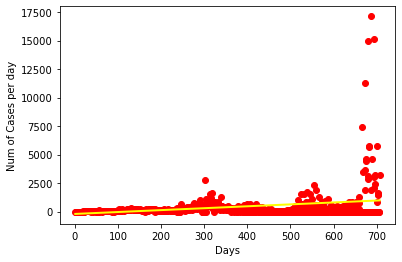

In [569]:
model1 = smf.ols('confirmed_daily~first_occurence',nc_county_w).fit()
plt.scatter(nc_county_w['first_occurence'],nc_county_w['confirmed_daily'],color = 'red')
plt.plot(nc_county_w['first_occurence'],model1.predict(nc_county_w),color='yellow',linewidth = 2)
plt.xlabel('Days')
plt.ylabel('Num of Cases per day')
plt.show()

### Trendline for Wake county

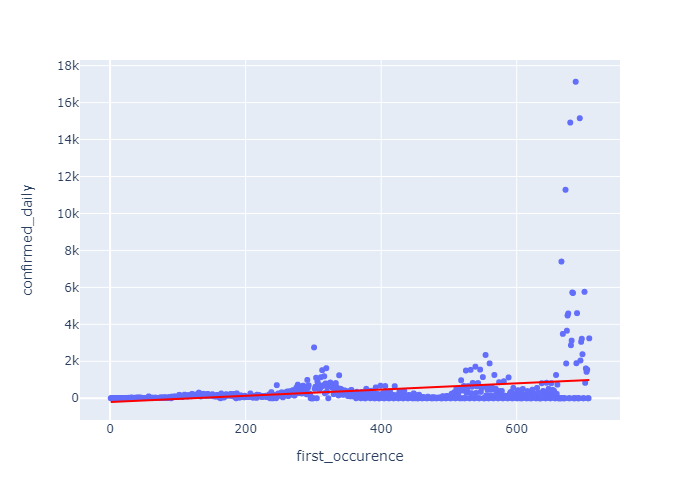

In [644]:
#Updated forecast for 7 days
fig = px.scatter(nc_county_w, x="first_occurence", y="confirmed_daily", trendline="ols",trendline_color_override="red")
#fig.show()
fig.write_image("2.png")
Image(filename="2.png")

## Linear regression for mecklenburg county

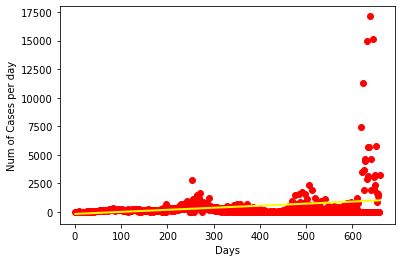

In [570]:
model1 = smf.ols('confirmed_daily~first_occurence',nc_county_m).fit()
plt.scatter(nc_county_m['first_occurence'],nc_county_m['confirmed_daily'],color = 'red')
plt.plot(nc_county_m['first_occurence'],model1.predict(nc_county_m),color='yellow',linewidth = 2)
plt.xlabel('Days')
plt.ylabel('Num of Cases per day')
plt.show()

### Trendline for mecklenburg county

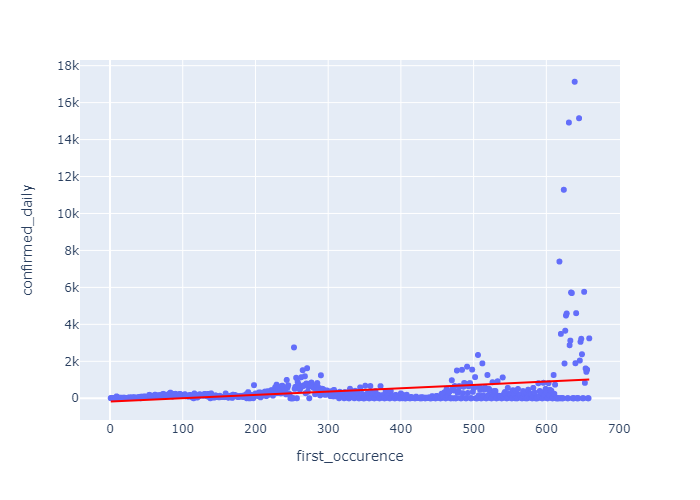

In [645]:
#Updated forecast for 7 days
fig = px.scatter(nc_county_m, x="first_occurence", y="confirmed_daily", trendline="ols",trendline_color_override="red")
#fig.show()
fig.write_image("2.png")
Image(filename="2.png")

## Linear regression for guilford county

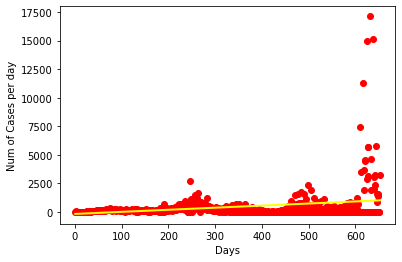

In [572]:
model1 = smf.ols('confirmed_daily~first_occurence',nc_county_g).fit()
plt.scatter(nc_county_g['first_occurence'],nc_county_g['confirmed_daily'],color = 'red')
plt.plot(nc_county_g['first_occurence'],model1.predict(nc_county_g),color='yellow',linewidth = 2)
plt.xlabel('Days')
plt.ylabel('Num of Cases per day')
plt.show()

### Trendline for guilford county

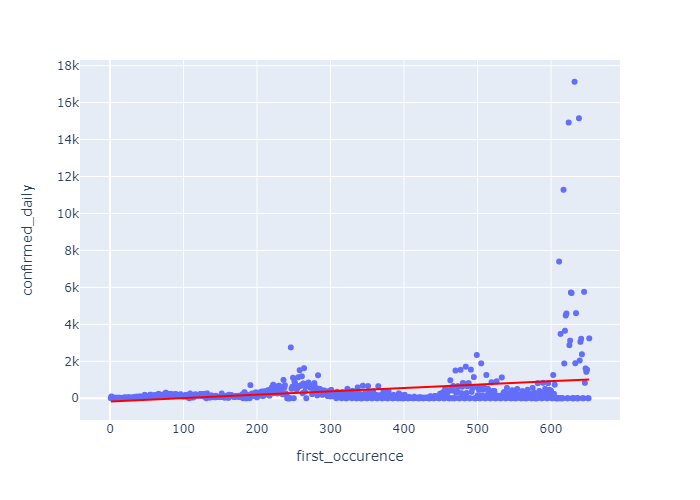

In [646]:
#Updated forecast for 7 days
fig = px.scatter(nc_county_g, x="first_occurence", y="confirmed_daily", trendline="ols",trendline_color_override="red")
#fig.show()
fig.write_image("2.png")
Image(filename="2.png")

## Linear regression for forsyth county


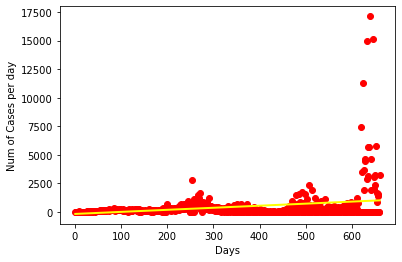

In [575]:
model1 = smf.ols('confirmed_daily~first_occurence',nc_county_f).fit()
plt.scatter(nc_county_f['first_occurence'],nc_county_f['confirmed_daily'],color = 'red')
plt.plot(nc_county_f['first_occurence'],model1.predict(nc_county_f),color='yellow',linewidth = 2)
plt.xlabel('Days')
plt.ylabel('Num of Cases per day')
plt.show()

### Trendline for forsyth county

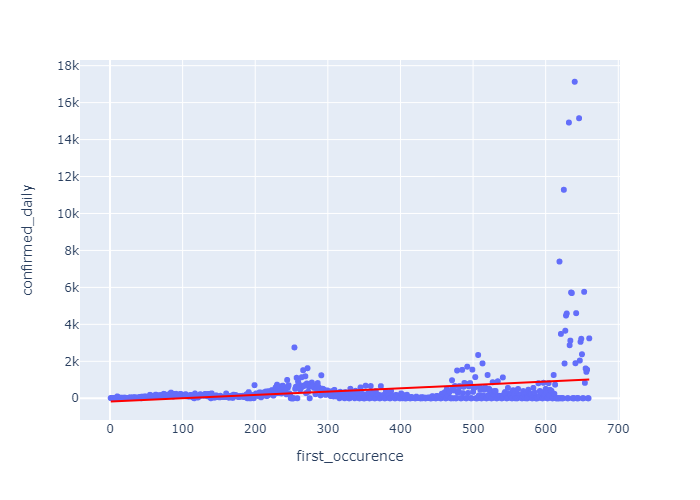

In [647]:
#Updated forecast for 7 days
fig = px.scatter(nc_county_f, x="first_occurence", y="confirmed_daily", trendline="ols",trendline_color_override="red")
#fig.show()
fig.write_image("2.png")
Image(filename="2.png")

## Linear regression for Union county

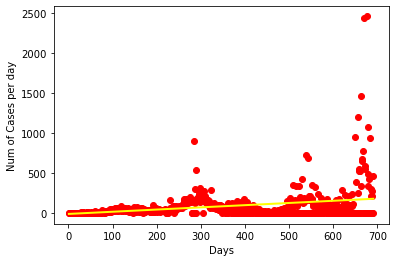

In [576]:
model1 = smf.ols('confirmed_daily~first_occurence',nc_county_u).fit()
plt.scatter(nc_county_u['first_occurence'],nc_county_u['confirmed_daily'],color = 'red')
plt.plot(nc_county_u['first_occurence'],model1.predict(nc_county_u),color='yellow',linewidth = 2)
plt.xlabel('Days')
plt.ylabel('Num of Cases per day')
plt.show()

### Trendline for Union county

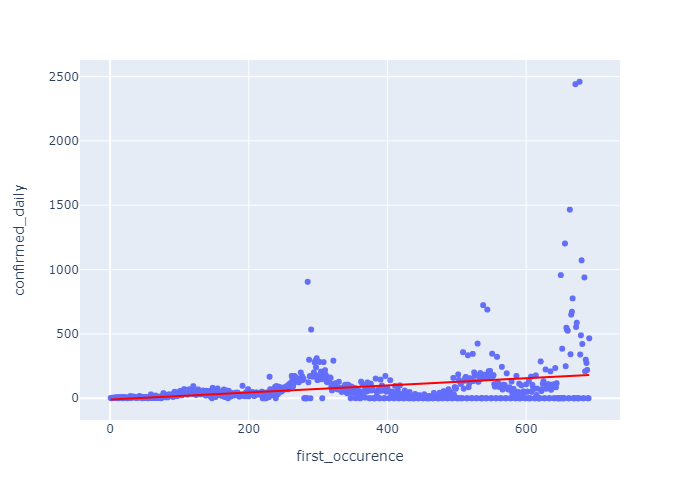

In [648]:
#Updated forecast for 7 days
fig = px.scatter(nc_county_u, x="first_occurence", y="confirmed_daily", trendline="ols",trendline_color_override="red")
#fig.show()
fig.write_image("2.png")
Image(filename="2.png")

Inferences about the 5 counties:
* From the linear regression plots of the 5 counties, it can be said that, Union county has the least number of cases with a peak of 2500 cases during the complete 748 day period.
* While other 4 counties have a peak of 17500 cases at some point in 748 days.
* All counties have a growing trend which is increasing untitl the last day.
* The county at the lowest risk is Union County.

### Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.

#### Here I am making use of the merged hospital dataset with the covid dataset generated by one of our team member in stage 1, that was uploaded on github

In [3]:
h_data = pd.read_csv('../../../../data/stage_4/hospital_dataset.csv')
#h_data = pd.read_csv('hospital_dataset.csv')

In [8]:
h_data

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,inpatient_beds,...,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_covid,total_staffed_adult_icu_beds,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,adult_icu_bed_utilization,reporting_cutoff_start,deaths_covid
0,0,statewide unallocated,AL,2020-01-22,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
1,0,statewide unallocated,AL,2020-01-23,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
2,0,statewide unallocated,AL,2020-01-24,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
3,0,statewide unallocated,AL,2020-01-25,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
4,0,statewide unallocated,AL,2020-01-26,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346471,56045,weston county,WY,2022-02-03,1491,17,6927,0,3,1766,...,93,96,134,0.451869,0.120823,0.054367,0.148438,0.410448,2/9/2022,2.0
2346472,56045,weston county,WY,2022-02-04,1496,17,6927,0,3,1766,...,93,96,134,0.451869,0.120823,0.054367,0.148438,0.410448,2/9/2022,2.0
2346473,56045,weston county,WY,2022-02-05,1496,17,6927,0,3,1766,...,93,96,134,0.451869,0.120823,0.054367,0.148438,0.410448,2/9/2022,2.0
2346474,56045,weston county,WY,2022-02-06,1496,17,6927,0,3,1766,...,93,96,134,0.451869,0.120823,0.054367,0.148438,0.410448,2/9/2022,2.0


In [7]:
h_data.columns

Index(['countyFIPS', 'County_Name', 'State', 'Date', 'Confirmed', 'Deaths',
       'population', 'critical_staffing_shortage_today_yes',
       'critical_staffing_shortage_today_no', 'inpatient_beds',
       'inpatient_beds_used', 'inpatient_beds_used_covid',
       'staffed_icu_adult_patients_confirmed_and_suspected_covid',
       'staffed_icu_adult_patients_confirmed_covid',
       'total_adult_patients_hospitalized_confirmed_and_suspected_covid',
       'total_adult_patients_hospitalized_confirmed_covid',
       'total_staffed_adult_icu_beds', 'inpatient_beds_utilization',
       'percent_of_inpatients_with_covid', 'inpatient_bed_covid_utilization',
       'adult_icu_bed_covid_utilization', 'adult_icu_bed_utilization',
       'reporting_cutoff_start', 'deaths_covid'],
      dtype='object')

In [9]:
h_data['Date'] = h_data.Date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))
#remove all empty rows, removing state unallocated.
h_data = h_data[h_data.countyFIPS != 0]

In [10]:
hos = h_data[['countyFIPS', 'County_Name', 'State', 'Date', 'Confirmed', 'Deaths','inpatient_beds',
       'inpatient_beds_used','inpatient_beds_utilization',
       'percent_of_inpatients_with_covid', 'inpatient_bed_covid_utilization',
       'adult_icu_bed_covid_utilization']]

In [11]:
hos['confirmed_daily'] = hos['Confirmed'].diff()
hos['deaths_daily'] = hos['Deaths'].diff()
hos = hos.iloc[1: , :]
hos

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,inpatient_beds,inpatient_beds_used,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,confirmed_daily,deaths_daily
749,1001,autauga county,AL,2020-01-23,0,0,15066,11277,0.748507,0.171831,0.129121,0.282855,0.0,0.0
750,1001,autauga county,AL,2020-01-24,0,0,15066,11277,0.748507,0.171831,0.129121,0.282855,0.0,0.0
751,1001,autauga county,AL,2020-01-25,0,0,15066,11277,0.748507,0.171831,0.129121,0.282855,0.0,0.0
752,1001,autauga county,AL,2020-01-26,0,0,15066,11277,0.748507,0.171831,0.129121,0.282855,0.0,0.0
753,1001,autauga county,AL,2020-01-27,0,0,15066,11277,0.748507,0.171831,0.129121,0.282855,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346471,56045,weston county,WY,2022-02-03,1491,17,1766,798,0.451869,0.120823,0.054367,0.148438,6.0,0.0
2346472,56045,weston county,WY,2022-02-04,1496,17,1766,798,0.451869,0.120823,0.054367,0.148438,5.0,0.0
2346473,56045,weston county,WY,2022-02-05,1496,17,1766,798,0.451869,0.120823,0.054367,0.148438,0.0,0.0
2346474,56045,weston county,WY,2022-02-06,1496,17,1766,798,0.451869,0.120823,0.054367,0.148438,0.0,0.0


In [12]:
hos

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,inpatient_beds,inpatient_beds_used,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,confirmed_daily,deaths_daily
749,1001,autauga county,AL,2020-01-23,0,0,15066,11277,0.748507,0.171831,0.129121,0.282855,0.0,0.0
750,1001,autauga county,AL,2020-01-24,0,0,15066,11277,0.748507,0.171831,0.129121,0.282855,0.0,0.0
751,1001,autauga county,AL,2020-01-25,0,0,15066,11277,0.748507,0.171831,0.129121,0.282855,0.0,0.0
752,1001,autauga county,AL,2020-01-26,0,0,15066,11277,0.748507,0.171831,0.129121,0.282855,0.0,0.0
753,1001,autauga county,AL,2020-01-27,0,0,15066,11277,0.748507,0.171831,0.129121,0.282855,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346471,56045,weston county,WY,2022-02-03,1491,17,1766,798,0.451869,0.120823,0.054367,0.148438,6.0,0.0
2346472,56045,weston county,WY,2022-02-04,1496,17,1766,798,0.451869,0.120823,0.054367,0.148438,5.0,0.0
2346473,56045,weston county,WY,2022-02-05,1496,17,1766,798,0.451869,0.120823,0.054367,0.148438,0.0,0.0
2346474,56045,weston county,WY,2022-02-06,1496,17,1766,798,0.451869,0.120823,0.054367,0.148438,0.0,0.0


### Checking hospital stats for NC

In [13]:
nc_hos = hos[hos['State']=='NC']

In [14]:
nc_hos = nc_hos.iloc[1: , :]
nc_hos

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,inpatient_beds,inpatient_beds_used,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,confirmed_daily,deaths_daily
1426437,37001,alamance county,NC,2020-01-23,0,0,23252,18691,0.803845,0.214769,0.172751,0.305667,0.0,0.0
1426438,37001,alamance county,NC,2020-01-24,0,0,23252,18691,0.803845,0.214769,0.172751,0.305667,0.0,0.0
1426439,37001,alamance county,NC,2020-01-25,0,0,23252,18691,0.803845,0.214769,0.172751,0.305667,0.0,0.0
1426440,37001,alamance county,NC,2020-01-26,0,0,23252,18691,0.803845,0.214769,0.172751,0.305667,0.0,0.0
1426441,37001,alamance county,NC,2020-01-27,0,0,23252,18691,0.803845,0.214769,0.172751,0.305667,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501231,37199,yancey county,NC,2022-02-03,4425,46,23252,18691,0.803845,0.214769,0.172751,0.305667,18.0,1.0
1501232,37199,yancey county,NC,2022-02-04,4439,48,23252,18691,0.803845,0.214769,0.172751,0.305667,14.0,2.0
1501233,37199,yancey county,NC,2022-02-05,4439,48,23252,18691,0.803845,0.214769,0.172751,0.305667,0.0,0.0
1501234,37199,yancey county,NC,2022-02-06,4439,48,23252,18691,0.803845,0.214769,0.172751,0.305667,0.0,0.0


### Determining first occurence of cases

#### Grouping the data by date

In [16]:
nc_hos = nc_hos.groupby(["Date"]).sum().reset_index()
nc_hos
#nc_hos.reset_index(inplace=True)
#nc_hos.drop('index',axis=1, inplace = True)

,Date,countyFIPS,Confirmed,Deaths,inpatient_beds,inpatient_beds_used,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,confirmed_daily,deaths_daily
0,2020-01-22,3672999,0,0,2301948,1850409,79.580638,21.262104,17.102389,30.261044,-2488512.0,-21200.0
1,2020-01-23,3710000,0,0,2325200,1869100,80.384483,21.476873,17.275140,30.566711,0.0,0.0
2,2020-01-24,3710000,0,0,2325200,1869100,80.384483,21.476873,17.275140,30.566711,0.0,0.0
3,2020-01-25,3710000,0,0,2325200,1869100,80.384483,21.476873,17.275140,30.566711,0.0,0.0
4,2020-01-26,3710000,0,0,2325200,1869100,80.384483,21.476873,17.275140,30.566711,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
743,2022-02-03,3710000,2456386,21027,2325200,1869100,80.384483,21.476873,17.275140,30.566711,14980.0,123.0
744,2022-02-04,3710000,2468806,21097,2325200,1869100,80.384483,21.476873,17.275140,30.566711,12420.0,70.0
745,2022-02-05,3710000,2468806,21097,2325200,1869100,80.384483,21.476873,17.275140,30.566711,0.0,0.0
746,2022-02-06,3710000,2468806,21097,2325200,1869100,80.384483,21.476873,17.275140,30.566711,0.0,0.0


In [18]:
#removing the first row
nc_hos = nc_hos.iloc[1: , :]
nc_hos

,Date,countyFIPS,Confirmed,Deaths,inpatient_beds,inpatient_beds_used,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,confirmed_daily,deaths_daily
1,2020-01-23,3710000,0,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0
2,2020-01-24,3710000,0,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0
3,2020-01-25,3710000,0,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0
4,2020-01-26,3710000,0,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0
5,2020-01-27,3710000,0,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
743,2022-02-03,3710000,2456386,21027,2325200,1869100,80.384483,21.476873,17.27514,30.566711,14980.0,123.0
744,2022-02-04,3710000,2468806,21097,2325200,1869100,80.384483,21.476873,17.27514,30.566711,12420.0,70.0
745,2022-02-05,3710000,2468806,21097,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0
746,2022-02-06,3710000,2468806,21097,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0


##### Finding the index when there is a firt occurence of cases

In [19]:
confirmed_day1 = nc_hos.confirmed_daily.ne(0).idxmax()
confirmed_day1

41

In [21]:
nc_hos = nc_hos.iloc[40: , :]
nc_hos.head()

,Date,countyFIPS,Confirmed,Deaths,inpatient_beds,inpatient_beds_used,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,confirmed_daily,deaths_daily
41,2020-03-03,3710000,1,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,1.0,0.0
42,2020-03-04,3710000,1,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0
43,2020-03-05,3710000,1,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0
44,2020-03-06,3710000,2,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,1.0,0.0
45,2020-03-07,3710000,2,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0


## First occurence calculation

In [23]:
nc_hos.insert(0, 'first_occurence',nc_hos.index-40)
nc_hos

,first_occurence,Date,countyFIPS,Confirmed,Deaths,inpatient_beds,inpatient_beds_used,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,confirmed_daily,deaths_daily
41,1,2020-03-03,3710000,1,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,1.0,0.0
42,2,2020-03-04,3710000,1,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0
43,3,2020-03-05,3710000,1,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0
44,4,2020-03-06,3710000,2,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,1.0,0.0
45,5,2020-03-07,3710000,2,0,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,703,2022-02-03,3710000,2456386,21027,2325200,1869100,80.384483,21.476873,17.27514,30.566711,14980.0,123.0
744,704,2022-02-04,3710000,2468806,21097,2325200,1869100,80.384483,21.476873,17.27514,30.566711,12420.0,70.0
745,705,2022-02-05,3710000,2468806,21097,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0
746,706,2022-02-06,3710000,2468806,21097,2325200,1869100,80.384483,21.476873,17.27514,30.566711,0.0,0.0


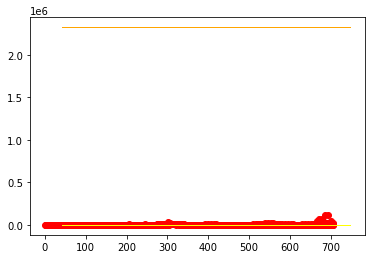

In [42]:
plt.scatter(nc_hos['first_occurence'],nc_hos['confirmed_daily'],color = 'red')
plt.plot(nc_hos['inpatient_beds'],color='orange',linewidth = 1)
plt.plot(nc_hos['inpatient_beds_utilization'],color='yellow',linewidth = 1)
#plt.plot(nc_hos['adult_icu_bed_covid_utilization'],color='magenta',linewidth = 2)

#### From the above plot it can be said that total number of inpatient beds (orange line) and total of inpatient beds utilization (yellow line) are not meeting. If these line meets at some points then we can say that it has reached a point of no return, which is not the case in this plot. So it has not reached a point of no return. 

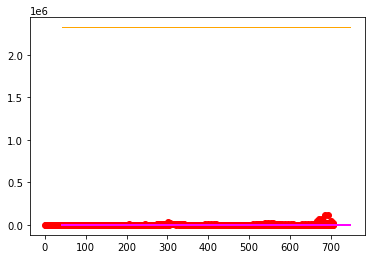

In [45]:
plt.scatter(nc_hos['first_occurence'],nc_hos['confirmed_daily'],color = 'red')
plt.plot(nc_hos['inpatient_beds'],color='orange',linewidth = 1)
#plt.plot(nc_hos['inpatient_beds_utilization'],color='yellow',linewidth = 1)
plt.plot(nc_hos['adult_icu_bed_covid_utilization'],color='magenta',linewidth = 2)

#### From the above plot it can be said that total number of inpatient beds (orange line) and total of adult_icu_bed_covid_utilization (yellow line) are not meeting. If these line meets at some points then we can say that it has reached a point of no return, which is not the case in this plot. So it has not reached a point of no return. 

### Checking hospital stats for Illinois

In [46]:
il_hos = hos[hos['State']=='IL']
il_hos = il_hos.iloc[1: , :]
il_hos

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,inpatient_beds,inpatient_beds_used,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,confirmed_daily,deaths_daily
446557,17001,adams county,IL,2020-01-23,0,0,29996,21620,0.720763,0.098164,0.070792,0.13066,0.0,0.0
446558,17001,adams county,IL,2020-01-24,0,0,29996,21620,0.720763,0.098164,0.070792,0.13066,0.0,0.0
446559,17001,adams county,IL,2020-01-25,0,0,29996,21620,0.720763,0.098164,0.070792,0.13066,0.0,0.0
446560,17001,adams county,IL,2020-01-26,0,0,29996,21620,0.720763,0.098164,0.070792,0.13066,0.0,0.0
446561,17001,adams county,IL,2020-01-27,0,0,29996,21620,0.720763,0.098164,0.070792,0.13066,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522847,17203,woodford county,IL,2022-02-03,9981,133,29996,21620,0.720763,0.098164,0.070792,0.13066,22.0,0.0
522848,17203,woodford county,IL,2022-02-04,10003,133,29996,21620,0.720763,0.098164,0.070792,0.13066,22.0,0.0
522849,17203,woodford county,IL,2022-02-05,10032,134,29996,21620,0.720763,0.098164,0.070792,0.13066,29.0,1.0
522850,17203,woodford county,IL,2022-02-06,10042,134,29996,21620,0.720763,0.098164,0.070792,0.13066,10.0,0.0


In [47]:
# Grouping the data by date
il_hos = il_hos.groupby(["Date"]).sum().reset_index()
il_hos

,Date,countyFIPS,Confirmed,Deaths,inpatient_beds,inpatient_beds_used,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,confirmed_daily,deaths_daily
0,2020-01-22,1727403,0,0,3029596,2183620,72.797040,9.914575,7.149959,13.196636,-2961269.0,-34169.0
1,2020-01-23,1744404,0,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0
2,2020-01-24,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,1.0,0.0
3,2020-01-25,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0
4,2020-01-26,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
743,2022-02-03,1744404,2947278,34054,3059592,2205240,73.517802,10.012739,7.220751,13.327296,8393.0,111.0
744,2022-02-04,1744404,2957334,34116,3059592,2205240,73.517802,10.012739,7.220751,13.327296,10056.0,62.0
745,2022-02-05,1744404,2962928,34205,3059592,2205240,73.517802,10.012739,7.220751,13.327296,5594.0,89.0
746,2022-02-06,1744404,2966648,34272,3059592,2205240,73.517802,10.012739,7.220751,13.327296,3720.0,67.0


In [48]:
##Removing the first row
il_hos = il_hos.iloc[1: , :]
il_hos

,Date,countyFIPS,Confirmed,Deaths,inpatient_beds,inpatient_beds_used,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,confirmed_daily,deaths_daily
1,2020-01-23,1744404,0,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0
2,2020-01-24,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,1.0,0.0
3,2020-01-25,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0
4,2020-01-26,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0
5,2020-01-27,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
743,2022-02-03,1744404,2947278,34054,3059592,2205240,73.517802,10.012739,7.220751,13.327296,8393.0,111.0
744,2022-02-04,1744404,2957334,34116,3059592,2205240,73.517802,10.012739,7.220751,13.327296,10056.0,62.0
745,2022-02-05,1744404,2962928,34205,3059592,2205240,73.517802,10.012739,7.220751,13.327296,5594.0,89.0
746,2022-02-06,1744404,2966648,34272,3059592,2205240,73.517802,10.012739,7.220751,13.327296,3720.0,67.0


In [49]:
#Finding the index where the first day of case is reported
confirmed_day1 = il_hos.confirmed_daily.ne(0).idxmax()
confirmed_day1

2

In [50]:
il_hos = il_hos.iloc[1: , :]
il_hos.head()

,Date,countyFIPS,Confirmed,Deaths,inpatient_beds,inpatient_beds_used,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,confirmed_daily,deaths_daily
2,2020-01-24,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,1.0,0.0
3,2020-01-25,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0
4,2020-01-26,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0
5,2020-01-27,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0
6,2020-01-28,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0


## First occurence calculation

In [51]:
il_hos.insert(0, 'first_occurence',il_hos.index-1)
il_hos

,first_occurence,Date,countyFIPS,Confirmed,Deaths,inpatient_beds,inpatient_beds_used,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,confirmed_daily,deaths_daily
2,1,2020-01-24,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,1.0,0.0
3,2,2020-01-25,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0
4,3,2020-01-26,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0
5,4,2020-01-27,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0
6,5,2020-01-28,1744404,1,0,3059592,2205240,73.517802,10.012739,7.220751,13.327296,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,742,2022-02-03,1744404,2947278,34054,3059592,2205240,73.517802,10.012739,7.220751,13.327296,8393.0,111.0
744,743,2022-02-04,1744404,2957334,34116,3059592,2205240,73.517802,10.012739,7.220751,13.327296,10056.0,62.0
745,744,2022-02-05,1744404,2962928,34205,3059592,2205240,73.517802,10.012739,7.220751,13.327296,5594.0,89.0
746,745,2022-02-06,1744404,2966648,34272,3059592,2205240,73.517802,10.012739,7.220751,13.327296,3720.0,67.0


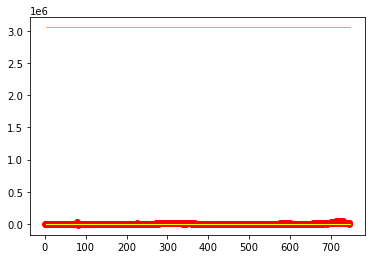

In [52]:
plt.scatter(il_hos['first_occurence'],il_hos['confirmed_daily'],color = 'red')
plt.plot(il_hos['inpatient_beds'],color='orange',linewidth = 1)
plt.plot(il_hos['inpatient_beds_utilization'],color='yellow',linewidth = 1)
#plt.plot(nc_hos['adult_icu_bed_covid_utilization'],color='magenta',linewidth = 2)

#### From the above plot it can be said that total number of inpatient beds (orange line) and total of inpatient beds utilization (yellow line) are not meeting. If these line meets at some points then we can say that it has reached a point of no return, which is not the case in this plot. So it has not reached a point of no return for Illinois hospital. 

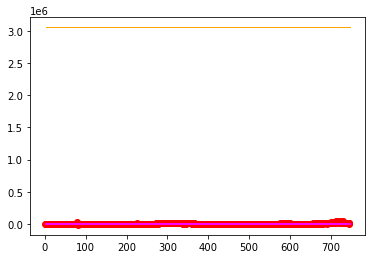

In [55]:
plt.scatter(il_hos['first_occurence'],il_hos['confirmed_daily'],color = 'red')
plt.plot(il_hos['inpatient_beds'],color='orange',linewidth = 1)
#plt.plot(il_hos['inpatient_beds_utilization'],color='yellow',linewidth = 1)
plt.plot(il_hos['adult_icu_bed_covid_utilization'],color='magenta',linewidth = 2)

#### From the above plot it can be said that total number of inpatient beds (orange line) and adult_icu_bed_covid_utilization (yellow line) are not meeting. If these line meets at some points then we can say that it has reached a point of no return, which is not the case in this plot. So it has not reached a point of no return for Illinois hospital. 

## Perform hypothesis tests on questions identified in Stage 2

### My enrichment data is ACS Demographic data. So I am testing the hypothesis generated in stage2 and stage3 of the project.

In [755]:
census_data  = pd.read_csv('../../../../data/stage_1/census_merged.csv')
#census_data  = pd.read_csv('census_merged.csv')
census_data

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,Total_pop,Male_total_population,Female_total_population,...,Population 15 to 19 Years old,Population 20 to 24 years old,Population 25 to 34 years old,Population 35 to 44 years old,Population 45 to 54 years old,Population 55 to 59 years old,Population 60 to 64 years old,Population 65 to 74 years old,Population 75 to 84 years old,Population 85 years and older
0,1003,baldwin county,AL,2020-01-22,0,0,223234,218022,105437,112585,...,13489,10426,23498,25990,30117,16569,15074,27152,13464,3827
1,1003,baldwin county,AL,2020-01-23,0,0,223234,218022,105437,112585,...,13489,10426,23498,25990,30117,16569,15074,27152,13464,3827
2,1003,baldwin county,AL,2020-01-24,0,0,223234,218022,105437,112585,...,13489,10426,23498,25990,30117,16569,15074,27152,13464,3827
3,1003,baldwin county,AL,2020-01-25,0,0,223234,218022,105437,112585,...,13489,10426,23498,25990,30117,16569,15074,27152,13464,3827
4,1003,baldwin county,AL,2020-01-26,0,0,223234,218022,105437,112585,...,13489,10426,23498,25990,30117,16569,15074,27152,13464,3827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603631,56025,natrona county,WY,2022-02-03,21413,255,79858,79115,39805,39310,...,5367,4211,11593,10426,9214,5844,5060,7181,3032,1687
603632,56025,natrona county,WY,2022-02-04,21501,255,79858,79115,39805,39310,...,5367,4211,11593,10426,9214,5844,5060,7181,3032,1687
603633,56025,natrona county,WY,2022-02-05,21501,255,79858,79115,39805,39310,...,5367,4211,11593,10426,9214,5844,5060,7181,3032,1687
603634,56025,natrona county,WY,2022-02-06,21501,255,79858,79115,39805,39310,...,5367,4211,11593,10426,9214,5844,5060,7181,3032,1687


In [756]:
census_data.columns

Index(['countyFIPS', 'County_Name', 'State', 'Date', 'Confirmed', 'Deaths',
       'population', 'Total_pop', 'Male_total_population',
       'Female_total_population', 'Population under 5 years of age',
       'Population 5 to 9 years old', 'Population 10 to 14 Years old',
       'Population 15 to 19 Years old', 'Population 20 to 24 years old',
       'Population 25 to 34 years old', 'Population 35 to 44 years old',
       'Population 45 to 54 years old', 'Population 55 to 59 years old',
       'Population 60 to 64 years old', 'Population 65 to 74 years old',
       'Population 75 to 84 years old', 'Population 85 years and older'],
      dtype='object')

In [757]:
census_data['confirmed_daily'] = census_data['Confirmed'].diff()
census_data['deaths_daily'] = census_data['Deaths'].diff()

In [758]:
census_data = census_data.iloc[1: , :]

In [759]:
census_data

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,Total_pop,Male_total_population,Female_total_population,...,Population 25 to 34 years old,Population 35 to 44 years old,Population 45 to 54 years old,Population 55 to 59 years old,Population 60 to 64 years old,Population 65 to 74 years old,Population 75 to 84 years old,Population 85 years and older,confirmed_daily,deaths_daily
1,1003,baldwin county,AL,2020-01-23,0,0,223234,218022,105437,112585,...,23498,25990,30117,16569,15074,27152,13464,3827,0.0,0.0
2,1003,baldwin county,AL,2020-01-24,0,0,223234,218022,105437,112585,...,23498,25990,30117,16569,15074,27152,13464,3827,0.0,0.0
3,1003,baldwin county,AL,2020-01-25,0,0,223234,218022,105437,112585,...,23498,25990,30117,16569,15074,27152,13464,3827,0.0,0.0
4,1003,baldwin county,AL,2020-01-26,0,0,223234,218022,105437,112585,...,23498,25990,30117,16569,15074,27152,13464,3827,0.0,0.0
5,1003,baldwin county,AL,2020-01-27,0,0,223234,218022,105437,112585,...,23498,25990,30117,16569,15074,27152,13464,3827,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603631,56025,natrona county,WY,2022-02-03,21413,255,79858,79115,39805,39310,...,11593,10426,9214,5844,5060,7181,3032,1687,98.0,0.0
603632,56025,natrona county,WY,2022-02-04,21501,255,79858,79115,39805,39310,...,11593,10426,9214,5844,5060,7181,3032,1687,88.0,0.0
603633,56025,natrona county,WY,2022-02-05,21501,255,79858,79115,39805,39310,...,11593,10426,9214,5844,5060,7181,3032,1687,0.0,0.0
603634,56025,natrona county,WY,2022-02-06,21501,255,79858,79115,39805,39310,...,11593,10426,9214,5844,5060,7181,3032,1687,0.0,0.0


#### I am referring this histogram and mean plot for cases and total population from Dr. Mohanty's notes on Hypothesis Testing

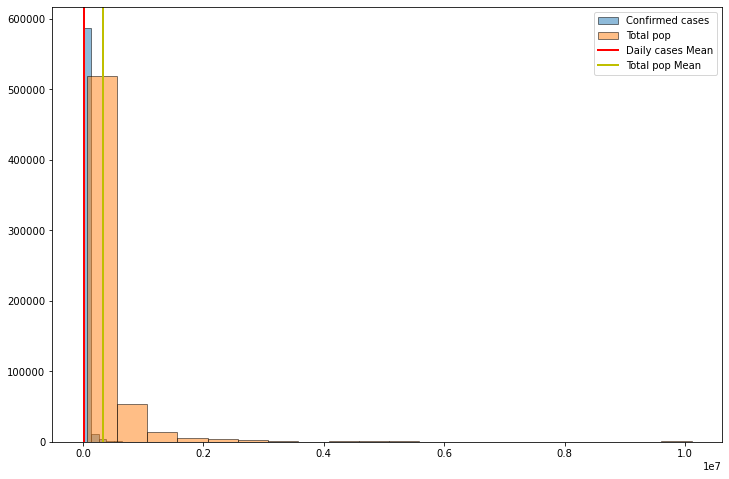

In [769]:
plt.figure(figsize=(12,8))

plt.hist(census_data['Confirmed'], bins=20, edgecolor='k', alpha=0.5, label='Confirmed cases')
plt.hist(census_data['Total_pop'], bins=20, edgecolor='k', alpha=0.5, label='Total pop')
plt.axvline(census_data['Confirmed'].mean(), color='r', linewidth=2, label='Daily cases Mean') 
plt.axvline(census_data['Total_pop'].mean(), color='y',  linewidth=2, label='Total pop Mean') 
plt.legend(loc='upper right')
plt.show()

To decide if the vlaue is lower or greater we would use
* Greater: p/2 <  𝛼  and t-statistic > 0
* Less: p/2 <  𝛼  and t-statistic < 0

### Hypothesis 1:
* If the total population increses, then total number of cases increses.

* Null Hypohesis: There is no significance between total population and cases rise. Both remain at the same level.
* Alternative Hypothesis:  As population increases, cases increases.

#### I am using this ttest patch of the code from Dr. Mohanty's notes on Hypothesis testing.
* https://github.com/UNCG-CSE/CSC-405-605_Spring_2022/blob/main/Class_Resources/Lecture_06/Statistics/05_Hypothesis.ipynb

In [771]:
stats.ttest_ind(a= census_data['confirmed_daily'],
                b= census_data['Total_pop'],
                equal_var = False
                )

Ttest_indResult(statistic=-438.54668567539557, pvalue=0.0)

* In hypthesis 1, p/2 < 0.05 and t-statistic < 0
* So our value lies in lower side of the distribution

#### Result
* The zero value of pvalue indicates that the null hypothesis is rejected and our test is statistically significant.
* With the rise in total population, there will be an increase in total confirmed cases. 


### Hypothesis 2:
* If the total male/female population increses, then total number of cases increses.

* Null Hypohesis: There is no significance between total male/female population and cases rise. Both remain at the same level.
* Alternative Hypothesis:  As population of male/female increases, cases increases.

In [770]:
stats.ttest_ind(a= census_data['confirmed_daily'],
                b= census_data['Male_total_population'],
                equal_var = False
                )

Ttest_indResult(statistic=-437.877710831253, pvalue=0.0)

* In hypthesis 1, p/2 < 0.05 and t-statistic < 0
* So our value lies in lower side of the distribution

In [741]:
stats.ttest_ind(a= census_data['confirmed_daily'],
                b= census_data['Female_total_population'],
                equal_var = False
                )

Ttest_indResult(statistic=-438.9447191173821, pvalue=0.0)

* In hypthesis 1, p/2 < 0.05 and t-statistic < 0
* So our value lies in lower side of the distribution

#### Result
* The zero value of pvalue indicates that the null hypothesis is rejected and our test is statistically significant.
* With the rise in total male/female population, there will be an increase in total confirmed cases. 


### Hypothesis 3:
* If the total middle aged population increses, then total number of cases increses.

* Null Hypohesis: There is no significance between total middle aged population and cases rise. Both remain at the same level.
* Alternative Hypothesis:  As population of middle aged increases, cases increases.

In [772]:
stats.ttest_ind(a= census_data['confirmed_daily'],
                b= census_data['Population 45 to 54 years old'],
                equal_var = False
                )

Ttest_indResult(statistic=-428.347066653315, pvalue=0.0)

* In hypthesis 1, p/2 < 0.05 and t-statistic < 0
* So our value lies in lower side of the distribution

#### Result
* The low value of pvalue indicates that the null hypothesis is rejected and our test is statistically significant.
* With the rise in middle-aged population, there will be an increase in total confirmed cases. 
